# [Exp-05]RockPaperScissors

## 라이브러리 확인

In [1]:
import tensorflow as tf
import numpy as np

print(tf.__version__)
print(np.__version__)

2022-08-02 21:53:35.022373: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-02 21:53:35.022396: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


2.9.1
1.23.1


## 데이터 불러오고 Resize 하기

In [2]:
from PIL import Image
import matplotlib.pyplot as plt
import glob
import os

In [3]:
def resize_images(img_path):
	images=glob.glob(img_path + "/*.jpg")  
    
	print(len(images), " images to be resized.")

    # 파일마다 모두 28x28 사이즈로 바꾸어 저장합니다.
	target_size=(28,28)
	for img in images:
		old_img=Image.open(img)
		new_img=old_img.resize(target_size,Image.ANTIALIAS)
		new_img.save(img, "JPEG")
    
	print(len(images), " images resized.")

In [4]:
# 가위 바위 보 이미지 불러와서 resize하기
image_dir_path1 = os.getenv("HOME") + "/Code/Exploration Submit/5/train1/scissor"
resize_images(image_dir_path1)

image_dir_path2 = os.getenv("HOME") + "/Code/Exploration Submit/5/train1/rock"
resize_images(image_dir_path2)

image_dir_path3 = os.getenv("HOME") + "/Code/Exploration Submit/5/train1/paper"
resize_images(image_dir_path3)

100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.


## train 데이터 설정

In [5]:
import numpy as np

def load_data(img_path, number_of_data=300):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path = os.getenv("HOME") + "/Code/Exploration Submit/5/train1"
(x_train, y_train)=load_data(image_dir_path)
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

학습데이터(x_train)의 이미지 개수는 300 입니다.
x_train shape: (300, 28, 28, 3)
y_train shape: (300,)


300개의 28x28x3(rgb) 입니다.

이미지 출력

라벨:  0


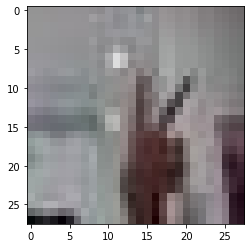

In [6]:
plt.imshow(x_train_norm[0])
print('라벨: ', y_train[0])

In [7]:
print(x_train_norm[0].shape)
print(y_train[0])


(28, 28, 3)
0


## 딥러닝 네트워크 설계하기

* 기존의 채널 1개에서 3개로 증가
* 최종 class의 개수가 10 -> 3

In [8]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

# model을 직접 만들어 보세요.
# Hint! model의 입력/출력부에 특히 유의해 주세요. 가위바위보 데이터셋은 MNIST 데이터셋과 어떤 점이 달라졌나요?
model=keras.models.Sequential()
model.add(keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(64, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 32)                5

2022-08-02 21:53:37.449383: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-02 21:53:37.449709: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-02 21:53:37.449747: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-08-02 21:53:37.449781: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-08-02 21:53:37.449864: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

## 딥러닝 네트워크 학습

In [9]:
x_train_norm.shape

(300, 28, 28, 3)

In [10]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model.fit(x_train_norm, y_train, epochs=10)

Epoch 1/10
10/10 [==============================] - 0s 8ms/step - loss: 1.0979 - accuracy: 0.2967
Epoch 2/10
10/10 [==============================] - 0s 10ms/step - loss: 1.0008 - accuracy: 0.6233
Epoch 3/10
10/10 [==============================] - 0s 10ms/step - loss: 0.8581 - accuracy: 0.7533
Epoch 4/10
10/10 [==============================] - 0s 10ms/step - loss: 0.6644 - accuracy: 0.7800
Epoch 5/10
10/10 [==============================] - 0s 8ms/step - loss: 0.4477 - accuracy: 0.9033
Epoch 6/10
10/10 [==============================] - 0s 9ms/step - loss: 0.2673 - accuracy: 0.9667
Epoch 7/10
10/10 [==============================] - 0s 11ms/step - loss: 0.1916 - accuracy: 0.9567
Epoch 8/10
10/10 [==============================] - 0s 8ms/step - loss: 0.1059 - accuracy: 0.9967
Epoch 9/10
10/10 [==============================] - 0s 10ms/step - loss: 0.0740 - accuracy: 0.9967
Epoch 10/10
10/10 [==============================] - 0s 10ms/step - loss: 0.0507 - accuracy: 0.9967


## 성능 확인

성능 확인을 위해 test data를 만들어 봅시다.

test 이미지를 resize 합시다.

In [11]:
test_image_dir_path1 = os.getenv("HOME") + "/Code/Exploration Submit/5/test/scissor"
resize_images(test_image_dir_path1)

test_image_dir_path2 = os.getenv("HOME") + "/Code/Exploration Submit/5/test/rock"
resize_images(test_image_dir_path2)

test_image_dir_path3 = os.getenv("HOME") + "/Code/Exploration Submit/5/test/paper"
resize_images(test_image_dir_path3)

100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.


In [12]:
test_image_dir_path = os.getenv("HOME") + "/Code/Exploration Submit/5/test"
(x_test, y_test)=load_data(test_image_dir_path)
x_test_norm = x_test/255.0

학습데이터(x_train)의 이미지 개수는 300 입니다.


제대로 되었는지 확인

(28, 28, 3)
라벨:  1


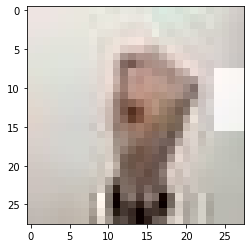

In [13]:
plt.imshow(x_test_norm[150])
print(x_test_norm[0].shape)
print('라벨: ', y_test[150])

evaluate 해서 test_accurcay를 구해봅시다.

In [14]:
test_loss, test_accuracy = model.evaluate(x_test_norm, y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

10/10 - 0s - loss: 2.7068 - accuracy: 0.3167 - 133ms/epoch - 13ms/step
test_loss: 2.7067670822143555 
test_accuracy: 0.3166666626930237


## 더 나은 모델 설정

정확도가 너무 낮으니 하이퍼 파라미터를 바꿔봅시다.

In [15]:
def RPS_predict(n_channel_1 = 16, n_channel_2=32 , n_dense=32, n_train_epoch=10):
    model=keras.models.Sequential()
    model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,3)))
    model.add(keras.layers.MaxPool2D(2,2))
    model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2,2)))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(n_dense, activation='relu'))
    model.add(keras.layers.Dense(3, activation='softmax'))

    # model.summary()
    model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

    # 모델 훈련 
    model.fit(x_train_norm, y_train, epochs=n_train_epoch, verbose = 1)

    # 모델 시험
    test_loss, test_accuracy = model.evaluate(x_test_norm, y_test, verbose=0)
    print(n_channel_1, n_channel_2, n_dense, n_train_epoch, ": test_loss: {} ".format(test_loss))
    print(n_channel_1, n_channel_2, n_dense, n_train_epoch, ": test_accuracy: {}".format(test_accuracy))

In [16]:
RPS_predict(8,16,8,12)

Epoch 1/12
10/10 [==============================] - 0s 3ms/step - loss: 1.0804 - accuracy: 0.4100
Epoch 2/12
10/10 [==============================] - 0s 4ms/step - loss: 1.0527 - accuracy: 0.6667
Epoch 3/12
10/10 [==============================] - 0s 3ms/step - loss: 1.0032 - accuracy: 0.8167
Epoch 4/12
10/10 [==============================] - 0s 4ms/step - loss: 0.9494 - accuracy: 0.8567
Epoch 5/12
10/10 [==============================] - 0s 3ms/step - loss: 0.8557 - accuracy: 0.8200
Epoch 6/12
10/10 [==============================] - 0s 3ms/step - loss: 0.7377 - accuracy: 0.8967
Epoch 7/12
10/10 [==============================] - 0s 4ms/step - loss: 0.6326 - accuracy: 0.7867
Epoch 8/12
10/10 [==============================] - 0s 3ms/step - loss: 0.4847 - accuracy: 0.9133
Epoch 9/12
10/10 [==============================] - 0s 4ms/step - loss: 0.3914 - accuracy: 0.9333
Epoch 10/12
10/10 [==============================] - 0s 4ms/step - loss: 0.3325 - accuracy: 0.9167
Epoch 11/12
10/10 [

train 데이터의 개수가 모자란 것 같습니다.  
train 데이터를 늘려보겠습니다.

여러개의 train을 사용하기위해 폴더에서 train 폴더만을 사용하겠습니다.

In [17]:
from os import listdir

list_dir = listdir('/home/aiffel/Code/Exploration Submit/5')
list_train = []
# print(list_dir)
for folder in sorted(list_dir):
    if(folder.startswith('train')):
        list_train.append(folder)

list_train

['train1', 'train2', 'train3', 'train4', 'train5', 'train6']

In [18]:
list_name = ['scissor', 'rock', 'paper']

for i in list_train:
    for j in list_name:
        image_dir_path = os.getenv("HOME") + "/Code/Exploration Submit/5/" + i + "/"+ j
        # print(image_dir_path)
        resize_images(image_dir_path)
    

100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.


In [19]:
# # train 2
# image_dir_path2_1 = os.getenv("HOME") + "/Code/Exploration Submit/5/train2/scissor"
# resize_images(image_dir_path2_1)
# image_dir_path2_2 = os.getenv("HOME") + "/Code/Exploration Submit/5/train2/rock"
# resize_images(image_dir_path2_2)
# image_dir_path2_3 = os.getenv("HOME") + "/Code/Exploration Submit/5/train2/paper"
# resize_images(image_dir_path2_3)

# # train 3
# image_dir_path3_1 = os.getenv("HOME") + "/Code/Exploration Submit/5/train3/scissor"
# resize_images(image_dir_path3_1)
# image_dir_path3_2 = os.getenv("HOME") + "/Code/Exploration Submit/5/train3/rock"
# resize_images(image_dir_path3_2)
# image_dir_path3_3 = os.getenv("HOME") + "/Code/Exploration Submit/5/train3/paper"
# resize_images(image_dir_path3_3)

# # train 4
# image_dir_path4_1 = os.getenv("HOME") + "/Code/Exploration Submit/5/train4/scissor"
# resize_images(image_dir_path4_1)
# image_dir_path4_2 = os.getenv("HOME") + "/Code/Exploration Submit/5/train4/rock"
# resize_images(image_dir_path4_2)
# image_dir_path4_3 = os.getenv("HOME") + "/Code/Exploration Submit/5/train4/paper"
# resize_images(image_dir_path4_3)

# # train 5
# image_dir_path5_1 = os.getenv("HOME") + "/Code/Exploration Submit/5/train5/scissor"
# resize_images(image_dir_path5_1)
# image_dir_path5_2 = os.getenv("HOME") + "/Code/Exploration Submit/5/train5/rock"
# resize_images(image_dir_path5_2)
# image_dir_path5_3 = os.getenv("HOME") + "/Code/Exploration Submit/5/train5/paper"
# resize_images(image_dir_path5_3)

# # train 6
# image_dir_path6_1 = os.getenv("HOME") + "/Code/Exploration Submit/5/train6/scissor"
# resize_images(image_dir_path6_1)
# image_dir_path6_2 = os.getenv("HOME") + "/Code/Exploration Submit/5/train6/rock"
# resize_images(image_dir_path6_2)
# image_dir_path6_3 = os.getenv("HOME") + "/Code/Exploration Submit/5/train6/paper"
# resize_images(image_dir_path6_3)

In [20]:
from os import listdir

# 실제 경로 = /home/aiffel/Code/Exploration Submit/5/train2/paper
# img_path  = /Code/Exploration Submit
# list_train = ['train1', 'train2', 'train3', 'train4', 'train5', 'train6']
# list_name = ['scissor', 'rock', 'paper']
def new_load_data(img_path, number_of_data=1800):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)
    idx = 0
    
    for i in list_train:
        for nidx, name in enumerate(list_name):
            print(i, nidx, name)
            for file in glob.iglob(img_path + "/" + i + "/" + name + "/*.jpg"):
                img = np.array(Image.open(file),dtype=np.int32)
                imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
                labels[idx] = nidx  # 가위 : 0, 바위 : 1, 보 : 2
                idx=idx+1
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

In [21]:
# def new_load_data(img_path1, img_path2, img_path3, img_path4, img_path5, img_path6, number_of_data=1800):  # 가위바위보 이미지 개수 총합에 주의하세요.
#     # 가위 : 0, 바위 : 1, 보 : 2
#     img_size=28
#     color=3
#     #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
#     imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
#     labels=np.zeros(number_of_data,dtype=np.int32)
    
#     idx=0
#     # train1 가위
#     for file in glob.iglob(img_path1+'/scissor/*.jpg'):
#         img = np.array(Image.open(file),dtype=np.int32)
#         imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
#         labels[idx]=0   # 가위 : 0
#         idx=idx+1
#     # train2 가위
#     for file in glob.iglob(img_path2+'/scissor/*.jpg'):
#         img = np.array(Image.open(file),dtype=np.int32)
#         imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
#         labels[idx]=0   # 가위 : 0
#         idx=idx+1
#     # train3 가위
#     for file in glob.iglob(img_path3+'/scissor/*.jpg'):
#         img = np.array(Image.open(file),dtype=np.int32)
#         imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
#         labels[idx]=0   # 가위 : 0
#         idx=idx+1
#     # train4 가위
#     for file in glob.iglob(img_path4+'/scissor/*.jpg'):
#         img = np.array(Image.open(file),dtype=np.int32)
#         imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
#         labels[idx]=0   # 가위 : 0
#         idx=idx+1
#     # train5 가위
#     for file in glob.iglob(img_path5+'/scissor/*.jpg'):
#         img = np.array(Image.open(file),dtype=np.int32)
#         imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
#         labels[idx]=0   # 가위 : 0
#         idx=idx+1
#     # train6 가위
#     for file in glob.iglob(img_path6+'/scissor/*.jpg'):
#         img = np.array(Image.open(file),dtype=np.int32)
#         imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
#         labels[idx]=0   # 가위 : 0
#         idx=idx+1
        
#     # train1 바위
#     for file in glob.iglob(img_path1+'/rock/*.jpg'):
#         img = np.array(Image.open(file),dtype=np.int32)
#         imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
#         labels[idx]=1   # 바위 : 1
#         idx=idx+1
#     # train2 바위
#     for file in glob.iglob(img_path2+'/rock/*.jpg'):
#         img = np.array(Image.open(file),dtype=np.int32)
#         imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
#         labels[idx]=1   # 바위 : 1
#         idx=idx+1 
#     # train3 바위
#     for file in glob.iglob(img_path3+'/rock/*.jpg'):
#         img = np.array(Image.open(file),dtype=np.int32)
#         imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
#         labels[idx]=1   # 바위 : 1
#         idx=idx+1  
#     # train4 바위
#     for file in glob.iglob(img_path4+'/rock/*.jpg'):
#         img = np.array(Image.open(file),dtype=np.int32)
#         imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
#         labels[idx]=1   # 바위 : 1
#         idx=idx+1
#     # train5 바위
#     for file in glob.iglob(img_path5+'/rock/*.jpg'):
#         img = np.array(Image.open(file),dtype=np.int32)
#         imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
#         labels[idx]=1   # 바위 : 1
#         idx=idx+1
#     # train6 바위
#     for file in glob.iglob(img_path6+'/rock/*.jpg'):
#         img = np.array(Image.open(file),dtype=np.int32)
#         imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
#         labels[idx]=1   # 바위 : 1
#         idx=idx+1
        
#     # trian1 보
#     for file in glob.iglob(img_path1+'/paper/*.jpg'):
#         img = np.array(Image.open(file),dtype=np.int32)
#         imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
#         labels[idx]=2   # 보 : 2
#         idx=idx+1
#     # trian2 보
#     for file in glob.iglob(img_path2+'/paper/*.jpg'):
#         img = np.array(Image.open(file),dtype=np.int32)
#         imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
#         labels[idx]=2   # 보 : 2
#         idx=idx+1
#     # trian3 보
#     for file in glob.iglob(img_path3+'/paper/*.jpg'):
#         img = np.array(Image.open(file),dtype=np.int32)
#         imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
#         labels[idx]=2   # 보 : 2
#         idx=idx+1
#     # trn4 보
#     for file in glob.iglob(img_path4+'/paper/*.jpg'):
#         img = np.array(Image.open(file),dtype=np.int32)
#         imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
#         labels[idx]=2   # 보 : 2
#         idx=idx+1
#     # trian5 보
#     for file in glob.iglob(img_path5+'/paper/*.jpg'):
#         img = np.array(Image.open(file),dtype=np.int32)
#         imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
#         labels[idx]=2   # 보 : 2
#         idx=idx+1    
#     # trian6 보    
#     for file in glob.iglob(img_path6+'/paper/*.jpg'):
#         img = np.array(Image.open(file),dtype=np.int32)
#         imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
#         labels[idx]=2   # 보 : 2
#         idx=idx+1
    
#     print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
#     return imgs, labels

In [22]:
# img_path1 = os.getenv("HOME") + "/Code/Exploration Submit/5/train1"
# img_path2 = os.getenv("HOME") + "/Code/Exploration Submit/5/train2"
# img_path3 = os.getenv("HOME") + "/Code/Exploration Submit/5/train3"
# img_path4 = os.getenv("HOME") + "/Code/Exploration Submit/5/train4"
# img_path5 = os.getenv("HOME") + "/Code/Exploration Submit/5/train5"
# img_path6 = os.getenv("HOME") + "/Code/Exploration Submit/5/train6"

# (x_train, y_train)=new_load_data(img_path1, img_path2, img_path3, img_path4, img_path5, img_path6, 1800)
# x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화

# print("x_train shape: {}".format(x_train_norm.shape))
# print("y_train shape: {}".format(y_train.shape))

In [23]:
img_path = os.getenv("HOME") + "/Code/Exploration Submit/5/"
(x_train, y_train)=new_load_data(img_path, 1800)
x_train_norm = x_train/255.0   # RPS_predict(32,32,64,14)입력은 0~1 사이의 값으로 정규화

print("x_train shape: {}".format(x_train_norm.shape))
print("y_train shape: {}".format(y_train.shape))

train1 0 scissor
train1 1 rock
train1 2 paper
train2 0 scissor
train2 1 rock
train2 2 paper
train3 0 scissor
train3 1 rock
train3 2 paper
train4 0 scissor
train4 1 rock
train4 2 paper
train5 0 scissor
train5 1 rock
train5 2 paper
train6 0 scissor
train6 1 rock
train6 2 paper
학습데이터(x_train)의 이미지 개수는 1800 입니다.
x_train shape: (1800, 28, 28, 3)
y_train shape: (1800,)


다시 구해봅니다.

In [24]:
# 16 32, 16 32, 32 64, 10 13 16

for i in range(1,3):
    for j in range(10, 20, 4):
        RPS_predict(16*i,16*i,32*i, j)
        # print(i, j)

Epoch 1/10
57/57 [==============================] - 1s 7ms/step - loss: 1.0729 - accuracy: 0.4261
Epoch 2/10
57/57 [==============================] - 0s 6ms/step - loss: 0.9589 - accuracy: 0.5717
Epoch 3/10
57/57 [==============================] - 0s 7ms/step - loss: 0.7273 - accuracy: 0.7494
Epoch 4/10
57/57 [==============================] - 0s 7ms/step - loss: 0.5574 - accuracy: 0.7933
Epoch 5/10
57/57 [==============================] - 0s 7ms/step - loss: 0.4492 - accuracy: 0.8333
Epoch 6/10
57/57 [==============================] - 0s 7ms/step - loss: 0.3635 - accuracy: 0.8683
Epoch 7/10
57/57 [==============================] - 0s 7ms/step - loss: 0.3226 - accuracy: 0.8844
Epoch 8/10
57/57 [==============================] - 0s 7ms/step - loss: 0.2682 - accuracy: 0.9094
Epoch 9/10
57/57 [==============================] - 0s 6ms/step - loss: 0.2251 - accuracy: 0.9294
Epoch 10/10
57/57 [==============================] - 0s 6ms/step - loss: 0.2046 - accuracy: 0.9339
16 16 32 10 : test_

accuracy가 0.603이 나왔습니다.